In [1]:
from google.cloud import storage
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import warnings
import os
from io import StringIO, BytesIO
import xarray as xr
import requests
import json
from pyproj import Geod
from datetime import datetime, timedelta
from scipy.spatial import cKDTree
from itertools import product

In [5]:
df = pd.read_csv('/home/muye/aus-env-modis/OCSE/lc12_byDistrict.csv')
df.head()

,polygon_name,vegetation_type,landcover_class,total_pixels,weighted_probability
0,BELCONNEN,370,0,9725,0.000474
1,BELCONNEN,370,1,9725,0.005868
2,BELCONNEN,370,2,9725,0.000040
3,BELCONNEN,370,3,9725,0.106571
4,BELCONNEN,370,4,9725,0.023914


In [8]:
np.unique(df['vegetation_type'])

array([364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376,
       377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [1]:
import json
import math

def create_grid(bbox, cell_size=1000):
    """
    Create a grid of square cells covering the given bounding box.
    
    Args:
        bbox: List of [min_x, min_y, max_x, max_y]
        cell_size: Size of each cell in the same units as bbox (default 1000m)
    
    Returns:
        Dictionary in GeoJSON format containing the grid
    """
    
    # Round to nearest cell_size to ensure complete coverage
    min_x = math.floor(bbox[0] / cell_size) * cell_size
    min_y = math.floor(bbox[1] / cell_size) * cell_size
    max_x = math.ceil(bbox[2] / cell_size) * cell_size
    max_y = math.ceil(bbox[3] / cell_size) * cell_size
    
    # Create features array
    features = []
    
    # Generate grid cells
    y = min_y
    while y < max_y:
        x = min_x
        while x < max_x:
            # Create cell polygon
            polygon = {
                "type": "Feature",
                "properties": {
                    "source_file": f"M{int(x/1000)}{int(y/1000)}10504.tab"
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[
                        [x, y],
                        [x + cell_size, y],
                        [x + cell_size, y + cell_size],
                        [x, y + cell_size],
                        [x, y]
                    ]]
                }
            }
            features.append(polygon)
            x += cell_size
        y += cell_size
    
    # Create GeoJSON structure
    grid_geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": "EPSG:32755"
            }
        },
        "features": features
    }
    
    return grid_geojson

# Read the bounding box from actbio_bb.geojson
with open('/home/muye/aus-env-modis/OCSE/actclf23_32755.geojson', 'r') as f:
    bb_data = json.load(f)

# Extract coordinates from the polygon
coords = bb_data['features'][0]['geometry']['coordinates'][0]
x_coords = [p[0] for p in coords]
y_coords = [p[1] for p in coords]

# Create bounding box
bbox = [
    min(x_coords),  # min_x
    min(y_coords),  # min_y
    max(x_coords),  # max_x
    max(y_coords)   # max_y
]

# Generate grid
grid = create_grid(bbox)

# Write output to file
with open('ACT1km_23.geojson', 'w') as f:
    json.dump(grid, f, indent=2)

# Print statistics
print(f"Generated grid with {len(grid['features'])} cells")
print(f"Bounding box: {bbox}")

Generated grid with 2160 cells
Bounding box: [675999.4703735964, 6064177.40125557, 719531.6707144382, 6111365.331818311]


### Aggregate 1km footprint to 5km

In [2]:
import json
import numpy as np
from shapely.geometry import Polygon, mapping
from collections import defaultdict

def aggregate_grid_cells(geojson_data):
    # Extract all cell coordinates and create a grid lookup
    cell_lookup = {}
    for feature in geojson_data['features']:
        coords = feature['geometry']['coordinates'][0]
        # Get the lower-left corner as the cell identifier
        cell_x = coords[0][0]  # First point, x coordinate
        cell_y = coords[0][1]  # First point, y coordinate
        cell_lookup[(cell_x, cell_y)] = feature

    # Function to get 5km block ID for a cell
    def get_block_id(x, y):
        block_x = int(x / 5000) * 5000
        block_y = int(y / 5000) * 5000
        return (block_x, block_y)

    # Group cells by their 5km block
    blocks = defaultdict(list)
    for (cell_x, cell_y), feature in cell_lookup.items():
        block_id = get_block_id(cell_x, cell_y)
        blocks[block_id].append(feature)

    # Create new features for blocks that have enough cells
    new_features = []
    for (block_x, block_y), block_cells in blocks.items():
        # Only process blocks that have at least one cell
        if block_cells:
            # Create a new 5km x 5km polygon
            block_coords = [
                [block_x, block_y],  # Lower left
                [block_x + 5000, block_y],  # Lower right
                [block_x + 5000, block_y + 5000],  # Upper right
                [block_x, block_y + 5000],  # Upper left
                [block_x, block_y]  # Close the polygon
            ]
            
            new_feature = {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [block_coords]
                },
                "properties": {
                    "cell_count": len(block_cells),
                    "original_files": [cell["properties"]["source_file"] for cell in block_cells]
                }
            }
            new_features.append(new_feature)

    # Create new FeatureCollection
    result = {
        "type": "FeatureCollection",
        "features": new_features
    }
    if 'crs' in geojson_data:
        result['crs'] = geojson_data['crs']

    return result

# Load and process the data
with open('/home/muye/aus-env-modis/OCSE/ACT1km_23.geojson', 'r') as f:
    data = json.load(f)

aggregated = aggregate_grid_cells(data)

# Save the result
with open('ACT23_5km_grid.geojson', 'w') as f:
    json.dump(aggregated, f, indent=2)

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read both GeoJSON files
original = gpd.read_file('grid21.geojson')
aggregated = gpd.read_file('ACT21_5km_grid.geojson')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot original 1km grid in light grey with thin lines
original.boundary.plot(ax=ax, color='grey', linewidth=0.5, alpha=0.5)

# Plot 5km aggregated grid in red with thicker lines
aggregated.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.8)

# Add title and legend
plt.title('Verification of Grid Aggregation\nOriginal 1km Grid (Grey) vs 5km Aggregated Grid (Red)')

# Add north arrow
ax.annotate('N', xy=(0.9, 0.9), xycoords='axes fraction', 
            fontsize=12, ha='center', va='center')
ax.arrow(0.9, 0.85, 0, 0.03, head_width=0.01, head_length=0.02, 
         fc='k', ec='k', transform=ax.transAxes)

# Add scale bar (approximate, based on coordinate system)
scalebar_length = 5000  # 5km in coordinate units
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
scale_x = x_min + (x_max - x_min) * 0.1
scale_y = y_min + (y_max - y_min) * 0.1
ax.plot([scale_x, scale_x + scalebar_length], [scale_y, scale_y], 'k-', linewidth=2)
ax.text(scale_x + scalebar_length/2, scale_y * 1.01, '5 km', 
        horizontalalignment='center')

# Make sure the aspect ratio is equal
ax.set_aspect('equal')

# Save the plot
plt.savefig('grid_verification.png', dpi=300, bbox_inches='tight')
plt.close()

# Print some statistics
print(f"Number of original 1km cells: {len(original)}")
print(f"Number of aggregated 5km blocks: {len(aggregated)}")

# Calculate coverage statistics
original_area = original.geometry.area.sum()
aggregated_area = aggregated.geometry.area.sum()
print(f"\nTotal area covered by original grid: {original_area/1e6:.2f} km²")
print(f"Total area covered by aggregated grid: {aggregated_area/1e6:.2f} km²")

Skipping field original_files: unsupported OGR type: 5


Number of original 1km cells: 2178
Number of aggregated 5km blocks: 114

Total area covered by original grid: 2178.00 km²
Total area covered by aggregated grid: 2850.00 km²


In [3]:
import json

def add_sequential_ids(geojson_data):
    # Add sequential IDs to each feature
    for i, feature in enumerate(geojson_data['features'], start=1):
        feature['properties']['id'] = i
    return geojson_data

# Load the GeoJSON file
with open('/home/muye/aus-env-modis/OCSE/ACT15_5km_grid.geojson', 'r') as f:
    data = json.load(f)

# Add the IDs
data_with_ids = add_sequential_ids(data)

# Save the modified GeoJSON
with open('/home/muye/aus-env-modis/OCSE/ACT15_5km_grid_with_ids.geojson', 'w') as f:
    json.dump(data_with_ids, f, indent=2)

# Print the first few features to verify
print("First 3 features with their new IDs:")
for feature in data_with_ids['features'][:3]:
    print(f"ID: {feature['properties']['id']}, Cell Count: {feature['properties']['cell_count']}")

First 3 features with their new IDs:
ID: 1, Cell Count: 14
ID: 2, Cell Count: 9
ID: 3, Cell Count: 9


In [ ]:
gsutil -m cp -r \
  "gs://terrakio-mass-requests/KG7zkkvurzSh23Ue70C5k7groNy2/ACT12_5km/data/ver1" \
  /home/muye/aus-env-modis/OCSE/lc12_byCells

gsutil -m cp -r \
  "gs://terrakio-mass-requests/KG7zkkvurzSh23Ue70C5k7groNy2/ACTVeg_1215_5km/data/ver1" \
  /home/muye/aus-env-modis/OCSE/vegCode_byCells


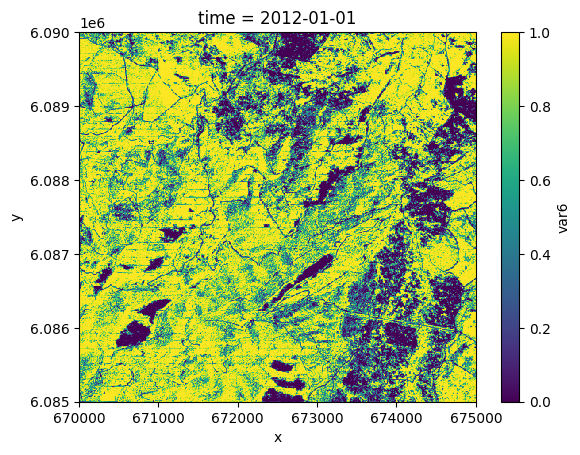

In [4]:
p = xr.open_dataset('/home/muye/aus-env-modis/OCSE/lc12_byCells/ver1/100.nc')
p.var6.isel(time=0).plot()

---

### 1km footprints for entire ACT
for 12, 15, and 21 years

In [2]:
import json

def generate_grid():
    # Updated bounds based on provided coordinates
    min_east = 674000  # Western boundary
    max_east = 720000  # Eastern boundary
    min_north = 6022000  # Southern boundary
    max_north = 6112000  # Northern boundary
    
    # Cell size in meters
    cell_size = 1000
    
    features = []
    
    # Generate grid cells
    for east in range(int(min_east), int(max_east), cell_size):
        for north in range(int(min_north), int(max_north), cell_size):
            # Create cell polygon
            polygon = {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[
                        [east, north],
                        [east + cell_size, north],
                        [east + cell_size, north + cell_size],
                        [east, north + cell_size],
                        [east, north]
                    ]]
                },
                "properties": {
                    "source_file": f"M{east//1000}{north//1000}10504.tab"
                }
            }
            features.append(polygon)
    
    # Create GeoJSON structure
    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": "EPSG:32755"
            }
        },
        "features": features
    }
    
    return geojson

# Generate and save the grid
grid = generate_grid()

# Calculate grid statistics
num_cells = len(grid['features'])
east_extent = (720000 - 674000) / 1000
north_extent = (6112000 - 6022000) / 1000

print(f"Generated {num_cells} grid cells")
print(f"Grid extends {east_extent:.0f}km east-west by {north_extent:.0f}km north-south")
print(f"Total area covered: {east_extent * north_extent:.0f} square kilometers")

with open('ACT_complete_grid.geojson', 'w') as f:
    json.dump(grid, f, indent=2)

Generated 4140 grid cells
Grid extends 46km east-west by 90km north-south
Total area covered: 4140 square kilometers
